In [30]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import scipy.signal
import scipy.optimize

import uncertainties.unumpy 
import uncertainties as uc

from sklearn.metrics import r2_score

In [2]:
def list_hdf5_files(start_path):
    hdf5_files = []
    for root, dirs, files in os.walk(start_path):
        for file in files:
            if file.endswith('.hdf5'):
                hdf5_files.append(os.path.join(root, file))
    return hdf5_files

def moving_average(data, window_size):   
    extended_data = np.concatenate([data, data[:window_size-1]])  # Extend the data for wrapping
    return np.convolve(extended_data, np.ones(window_size), 'valid')[:len(data)] / window_size

def param_cosine(x, a, b, c, d):
    return a * np.cos(b * (x - c)) + d




In [3]:
data_dir = "flux sweep cavity"
DATA_ROOT = "data"

path = os.path.join(DATA_ROOT, data_dir)

hdf5_files = list_hdf5_files(path)
hdf5_files

['data\\flux sweep cavity\\092656_flux-sweep_qb1\\092656_flux-sweep_qb1.hdf5',
 'data\\flux sweep cavity\\133657_flux-sweep_qb1\\133657_flux-sweep_qb1.hdf5',
 'data\\flux sweep cavity\\161853_flux-sweep_qb1\\161853_flux-sweep_qb1.hdf5']

In [4]:
f = h5py.File(hdf5_files[2])
data = np.array(list(f["Experimental Data"]["Data"]))
freq = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["freqs"])) * 1e-9
volt = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["volts"])) 

volt = volt[::-1]

y = np.abs(data[:,2] + 1j * data[:,3])
y = np.reshape(y, (len(volt), len(freq)))
y = np.flipud(y)

In [5]:
smoothed_y = np.zeros_like(y)
for i in range(len(y)):
    smoothed_y[i] = moving_average(y[i], 10)

max_freq = np.argmax(y, 1)

0.9716276017903345

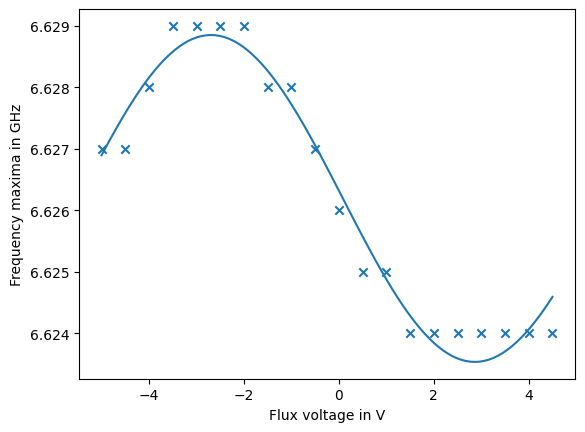

In [6]:
opt, _ = scipy.optimize.curve_fit(param_cosine, volt, freq[max_freq], [0.0026, 0.5, 2, 6.626])
x = np.linspace(np.min(volt), np.max(volt), 100)
plt.scatter(volt, freq[max_freq], marker="x")

plt.plot(x, param_cosine(x, *opt))
plt.ylabel("Frequency maxima in GHz")
plt.xlabel("Flux voltage in V")
r2_score(freq[max_freq], param_cosine(volt, *opt))

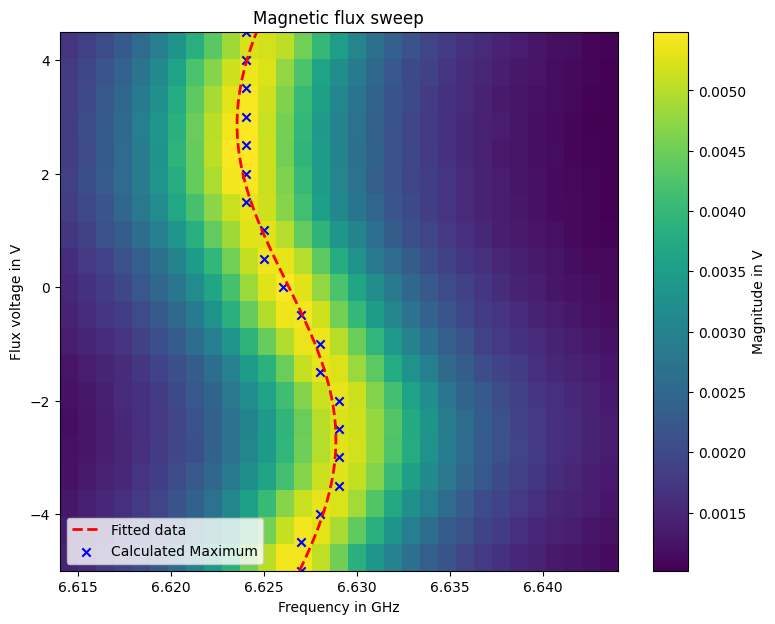

In [7]:
plt.figure(figsize=(9, 7))
plt.title("Magnetic flux sweep")
im = plt.imshow(y, aspect='auto', extent=[np.min(freq), np.max(freq), np.min(volt), np.max(volt)])
plt.plot(param_cosine(x, *opt), x, color="red", linestyle="--", linewidth=2, label="Fitted data")

plt.scatter(freq[max_freq], volt, marker="x", color="blue", label="Calculated Maximum")
plt.ylabel("Flux voltage in V")
plt.xlabel("Frequency in GHz")
bar = plt.colorbar(im, aspect=15)
bar.set_label("Magnitude in V")
plt.legend(loc="lower left")

plt.show()

In [8]:
f = h5py.File(hdf5_files[1])
data = np.array(list(f["Experimental Data"]["Data"]))
freq = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["freqs"])) * 1e-9
volt = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["volts"])) 

volt = volt[::-1]

y = np.abs(data[:,2] + 1j * data[:,3])
y = np.reshape(y, (len(volt), len(freq)))
y = np.flipud(y)

In [9]:
smoothed_y = np.zeros_like(y)
for i in range(len(y)):
    smoothed_y[i] = moving_average(y[i], 10)

max_freq = np.argmax(y, 1)

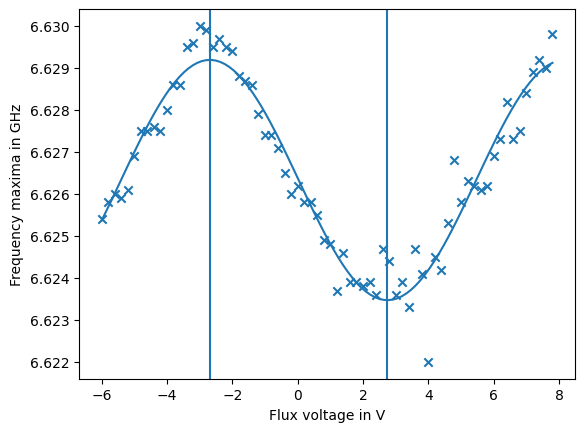

In [23]:
opt, cov = scipy.optimize.curve_fit(param_cosine, volt, freq[max_freq], [0.0026, 0.5, 2, 6.626])
x = np.linspace(np.min(volt), np.max(volt), 100)
plt.scatter(volt, freq[max_freq], marker="x")

plt.plot(x, param_cosine(x, *opt))
plt.ylabel("Frequency maxima in GHz")
plt.xlabel("Flux voltage in V")
plt.axvline(-np.pi/opt[1]  + opt[2])  
plt.axvline(opt[2])
r2_score(freq[max_freq], param_cosine(volt, *opt))
    
cov = np.diag(cov)

In [47]:
params = uncertainties.unumpy.uarray(opt, np.sqrt(cov))
maximal_val_of_the_thing = -params[0] - params[3]
print(f"{maximal_val_of_the_thing:L}")

-6.62347 \pm 0.00012


In [44]:
print(f"{params[2] :L}")

2.75 \pm 0.06


2.7486236706226963+/-0.06377028976409617

In [46]:
dwawed = uc.wrap(param_cosine)(params[2], *params)
print(f"{dwawed:L}")

6.62347 \pm 0.00012


In [33]:
param_cosine( opt[2], *opt)

6.623470768898654

In [14]:
freq[0] - freq[2]

-0.00019999999999953388

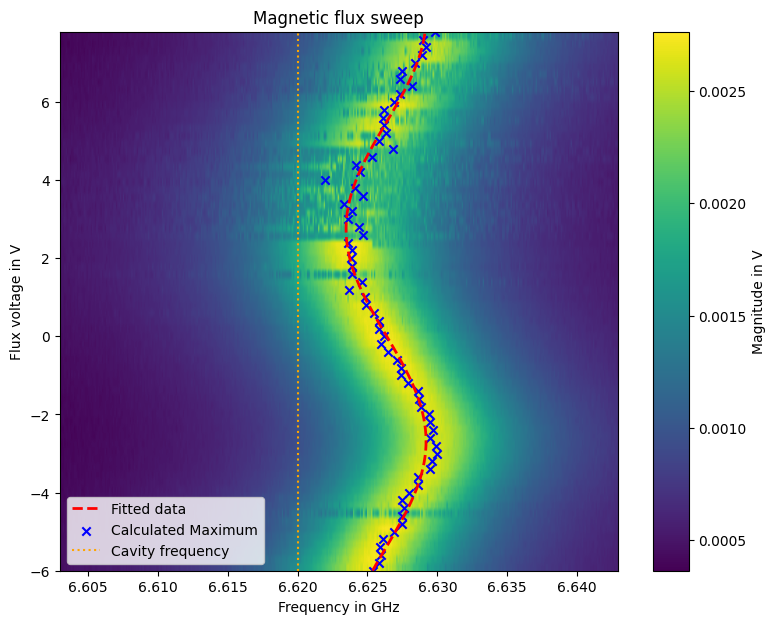

In [15]:
plt.figure(figsize=(9, 7))
plt.title("Magnetic flux sweep")
im = plt.imshow(y, aspect='auto', extent=[np.min(freq), np.max(freq), np.min(volt), np.max(volt)])
plt.plot(param_cosine(x, *opt), x, color="red", linestyle="--", linewidth=2, label="Fitted data")

plt.scatter(freq[max_freq], volt, marker="x", color="blue", label="Calculated Maximum")
plt.ylabel("Flux voltage in V")
plt.xlabel("Frequency in GHz")
bar = plt.colorbar(im, aspect=15)
bar.set_label("Magnitude in V")
plt.axvline(6.62, label="Cavity frequency", color="orange", linestyle=":")
plt.legend(loc="lower left")
plt.savefig("rsc/magnetic_flux_sweep1.pdf", bbox_inches="tight")
plt.show()